In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
from mnist import MNIST
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32)
print("Done.")

Loading dataset....
Done.


In [3]:
del y_train
del y_test
del mndata
# for tanh
X_train=X_train*2 - 1
X_test=X_test*2 - 1
X_train=np.concatenate([X_train,X_test]).reshape(-1,28,28,1)

In [4]:
X_train=X_train.repeat(3,axis=3)

In [5]:
import sys
sys.path.append("../dnn_from_scratch")

In [6]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,conv2dtranspose,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 407
Seed: 828


In [7]:
def generator():
    model=Sequential()
    model.add(dense(128*7*7,activation=functions.leakyRelu,input_shape=100))
    model.add(reshape((7,7,128)))
#     model.add(upsampling())
#     model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(64,kernel_size=5,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(upsampling())
#     model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu))
    model.add(conv2dtranspose(32,kernel_size=5,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(conv2d(3,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 6272)               leakyRelu        633472
__________________________________________________________________________________________
2 reshape(reshape)        (None, 7, 7, 128)          echo             0
__________________________________________________________________________________________
3 conv2dtranspose(conv2dt (None, 14, 14, 64)         leakyRelu        204864
__________________________________________________________________________________________
4 BatchNormalization(Batc (None, 14, 14, 64)         echo             256
__________________________________________________________________________________________
5 co

In [8]:
def discriminator():
    model=Sequential()
    model.add(conv2d(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu,input_shape=(28,28,3)))
#     model.add(max_pool())
    model.add(dropout(0.25))
    model.add(conv2d(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
#     model.add(max_pool())
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(flatten())
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dropout(0.2))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 28, 28, 3)          echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 14, 14, 32)         leakyRelu        896
__________________________________________________________________________________________
2 dropout(dropout)        (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
3 conv2d(conv2d)          (None, 7, 7, 64)           leakyRelu        18496
__________________________________________________________________________________________
4 BatchNormalization(Batc (None, 7, 7, 64)           echo             256
__________________________________________________________________________________________
5 dropou

In [9]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [10]:
noise=np.random.randn(64,100).astype(np.float32)
gen=g.predict(noise)

In [11]:
def gen_sample():
    noise=np.random.randn(1,100).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow((gen.reshape(28,28,3)+1)/2, cmap='Greys')
    plt.show()
    print(d.predict(gen)[0])

In [12]:
def run():
    batch_size=64
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
#         X = np.concatenate([real_images,generated_images])
        # Train discriminator
        y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
        y_fake=np.random.uniform(0,0.1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%60:
            gen_sample()
        print("\rProgress: {:.2f} %     Dloss: {}    err: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,err.sum(),time()-stt),end='')

EPOCH: 1 / 5


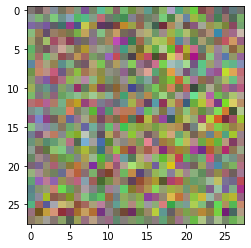

[0.6327869]
Progress: 5.39 %     Dloss: 15.156736373901367    err: 83.01655578613281     Sample time: 1.068s    ___

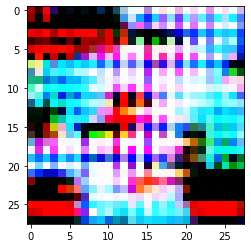

[6.831073e-06]
Progress: 10.88 %     Dloss: 14.1094970703125    err: -110.4902572631836     Sample time: 1.098s    _ _

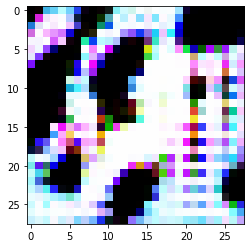

[5.1035187e-07]
Progress: 16.37 %     Dloss: 16.584117889404297    err: -21.55670166015625     Sample time: 1.068s    __

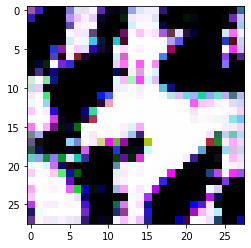

[0.00275849]
Progress: 21.85 %     Dloss: 14.409769058227539    err: 34.05521774291992     Sample time: 1.088s    ___

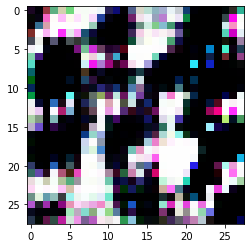

[0.00154054]
Progress: 27.34 %     Dloss: 16.7847957611084    err: 91.440185546875     Sample time: 1.074s    _   __

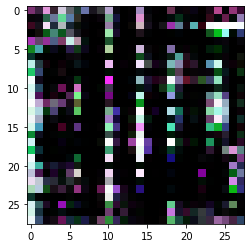

[0.00071482]
Progress: 32.82 %     Dloss: 22.842124938964844    err: 122.54157257080078     Sample time: 1.081s    __

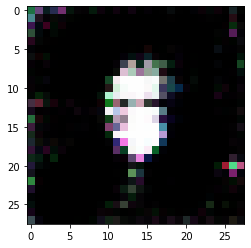

[0.15031753]
Progress: 38.31 %     Dloss: 33.38543701171875    err: 29.62373161315918     Sample time: 1.078s    _ __

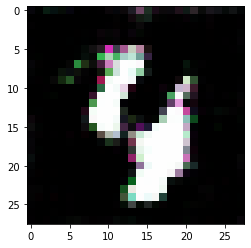

[0.00094319]
Progress: 43.79 %     Dloss: 40.06875228881836    err: 14.071083068847656     Sample time: 1.079s    __

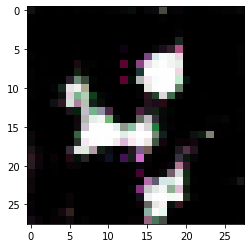

[0.00023379]
Progress: 49.28 %     Dloss: 34.783729553222656    err: 27.240140914916992     Sample time: 1.747s    __

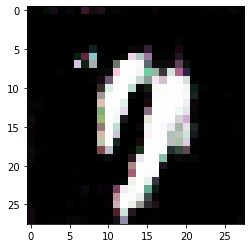

[0.00423345]
Progress: 54.77 %     Dloss: 24.07699203491211    err: 6.662596702575684     Sample time: 1.404s    _____

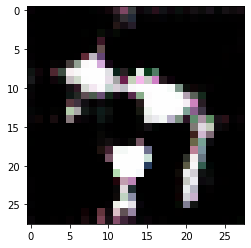

[0.00312677]
Progress: 60.25 %     Dloss: 36.82978820800781    err: 18.645631790161133     Sample time: 1.206s    ___

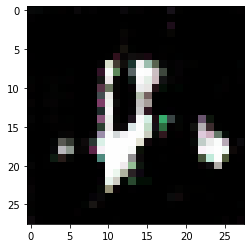

[3.38394e-05]
Progress: 63.45 %     Dloss: 32.24900436401367    err: -2.118232488632202     Sample time: 1.331s    ___

In [ ]:
epochs=5
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

In [ ]:
noise=np.random.randn(128,100).astype(np.float32)
gen=g.predict(noise)
gen_sample()
img=X_train[np.random.randint(low=0,high=X_train.shape[0],size=1)]
plt.imshow((img.reshape(28,28,3)+1)/2, cmap='Greys')
plt.show()
print(d.predict(img))

In [ ]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
noise=np.random.randn(25,100).astype(np.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.imshow((gen[i].squeeze()+1)/2, cmap='Greys')